Extracting Data/DIV2K_train_LR_bicubic_X2.zip -> /tmp
Extracting Data/DIV2K_valid_LR_bicubic_X2.zip -> /tmp
Directory: /tmp/DIV2K_train_LR_bicubic/X2
Total PNG images: 800
Sample filenames: ['0001x2.png', '0002x2.png', '0003x2.png', '0004x2.png', '0005x2.png', '0006x2.png', '0007x2.png', '0008x2.png', '0009x2.png', '0010x2.png']
Width: min 558, max 1020, mean 985
Height: min 324, max 1020, mean 717


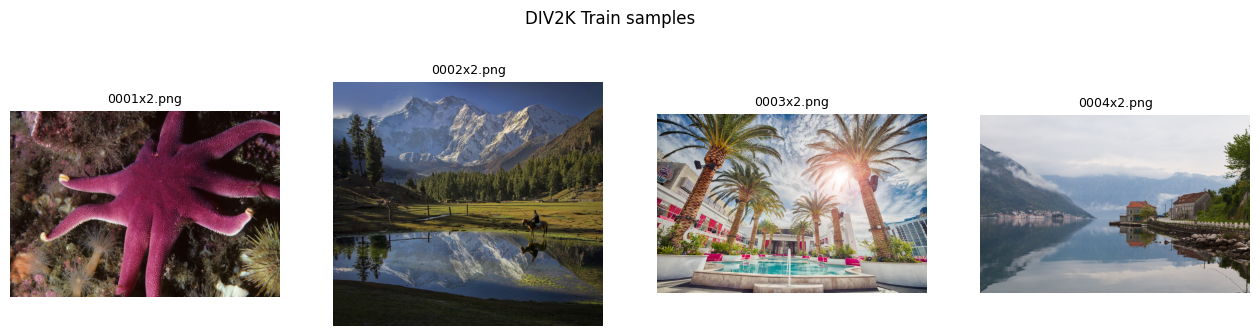

Directory: /tmp/DIV2K_valid_LR_bicubic/X2
Total PNG images: 100
Sample filenames: ['0801x2.png', '0802x2.png', '0803x2.png', '0804x2.png', '0805x2.png', '0806x2.png', '0807x2.png', '0808x2.png', '0809x2.png', '0810x2.png']
Width: min 678, max 1020, mean 989
Height: min 408, max 1020, mean 725


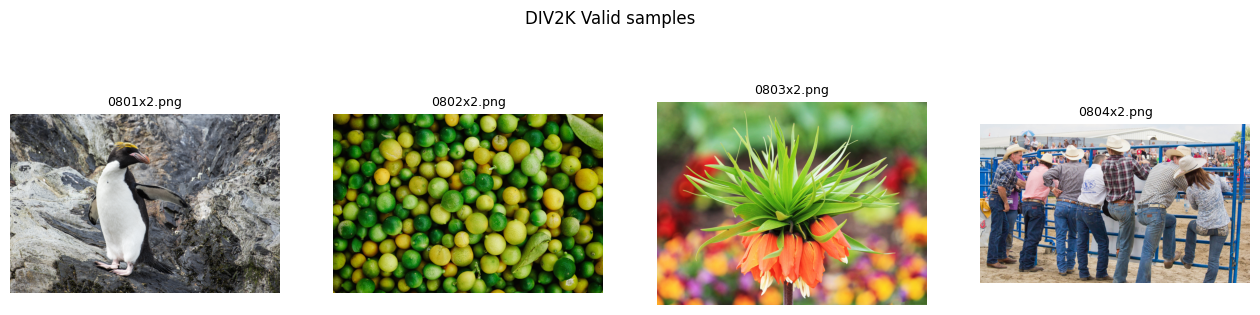

In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt



import os
import zipfile
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Paths to zip files in the project Data/ folder
local_zip_train = '../Data/DIV2K_train_LR_bicubic_X2.zip'
local_zip_test ='../Data/DIV2K_valid_LR_bicubic_X2.zip'

# Extract each archive (if not already extracted) into /tmp
def safe_extract(zip_path, dest_dir='/tmp'):
    if not os.path.exists(zip_path):
        print(f"Zip not found: {zip_path!r}")
        return None
    # determine top-level folder name in the archive to build the images path
    with zipfile.ZipFile(zip_path, 'r') as z:
        top_level = z.namelist()[0].split('/')[0]
        extract_path = os.path.join(dest_dir, top_level)
        if not os.path.isdir(extract_path):
            print(f"Extracting {zip_path} -> {dest_dir}")
            z.extractall(dest_dir)
        else:
            print(f"Already extracted: {extract_path}")
    return extract_path

train_root = safe_extract(local_zip_train, '/tmp')
test_root = safe_extract(local_zip_test, '/tmp')

# The DIV2K zips contain a nested folder like DIV2K_train_LR_bicubic/X2/
def find_image_folder(root):
    if root is None:
        return None
    # common nested path components seen in the archive
    candidates = [
        os.path.join(root, 'DIV2K_train_LR_bicubic', 'X2'),
        os.path.join(root, 'DIV2K_valid_LR_bicubic', 'X2'),
        os.path.join(root, 'DIV2K_train_LR_bicubic/X2'),
        os.path.join(root, 'DIV2K_valid_LR_bicubic/X2'),
    ]
    for c in candidates:
        if os.path.isdir(c):
            return c
    # fallback: find first folder containing many png files
    for dirpath, dirs, files in os.walk(root):
        if any(f.lower().endswith('.png') for f in files):
            return dirpath
    return None

train_images_dir = find_image_folder(train_root)
test_images_dir = find_image_folder(test_root)

def summarize_and_show(dir_path, n_show=4, title=None):
    if not dir_path or not os.path.isdir(dir_path):
        print(f"No images directory found at {dir_path!r}")
        return
    files = sorted(glob.glob(os.path.join(dir_path, '*.png')))
    print("="*60)
    print(f"Directory: {dir_path}")
    print(f"Total PNG images: {len(files)}")
    print("Sample filenames:", [os.path.basename(f) for f in files[:10]])
    # basic size stats
    sizes = []
    for fp in files:
        try:
            with Image.open(fp) as im:
                sizes.append(im.size)  # (width, height)
        except Exception:
            continue
    if sizes:
        widths = [s[0] for s in sizes]
        heights = [s[1] for s in sizes]
        print(f"Width: min {min(widths)}, max {max(widths)}, mean {int(np.mean(widths))}")
        print(f"Height: min {min(heights)}, max {max(heights)}, mean {int(np.mean(heights))}")
    # show few images
    to_show = files[:n_show]
    if not to_show:
        return
    plt.figure(figsize=(4*len(to_show), 4))
    for i, fp in enumerate(to_show):
        img = Image.open(fp).convert('RGB')
        ax = plt.subplot(1, len(to_show), i+1)
        ax.imshow(np.array(img))
        ax.set_title(os.path.basename(fp), fontsize=9)
        ax.axis('off')
    plt.suptitle(title or os.path.basename(dir_path))
    plt.show()

summarize_and_show(train_images_dir, n_show=4, title="DIV2K Train samples")
summarize_and_show(test_images_dir, n_show=4, title="DIV2K Valid samples")




### Get and Remove gray scale images

Grayscale images taht should be removed : ['/tmp/DIV2K_train_LR_bicubic/X2/0014x2.png', '/tmp/DIV2K_train_LR_bicubic/X2/0230x2.png', '/tmp/DIV2K_train_LR_bicubic/X2/0769x2.png', '/tmp/DIV2K_train_LR_bicubic/X2/0800x2.png']


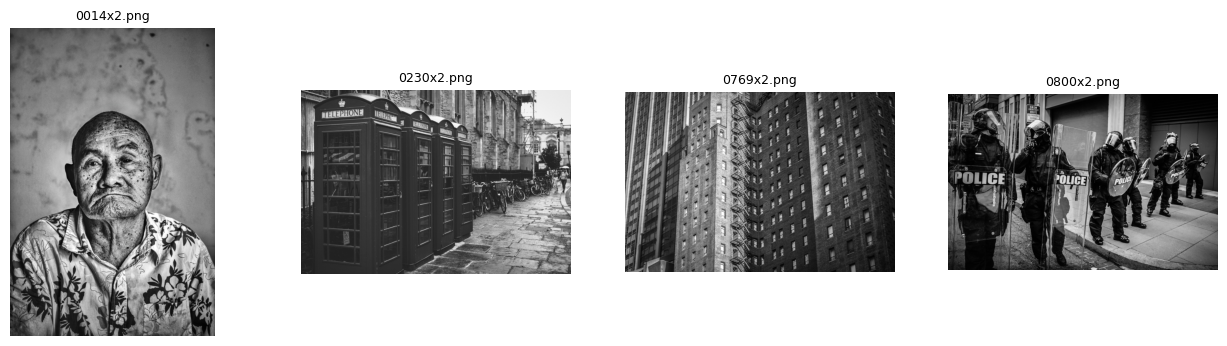

In [3]:
from skimage import color,io

files = sorted(glob.glob(os.path.join(train_images_dir, '*.png')))
to_remove = []

for image in files :
    rgb = io.imread(image)
    # Convert RGB → LAB
    lab = color.rgb2lab(rgb)

     # Split channels
    L = lab[:,:,0]
    a = lab[:,:,1]
    b = lab[:,:,2]

    if np.abs(np.mean(a)) < 0.1 and np.abs(np.mean(b)) < 0.1:
        to_remove.append(image)



print(f"Grayscale images taht should be removed : {to_remove}")
plt.figure(figsize=(4*len(to_remove), 4))
for i, fp in enumerate(to_remove):
        img = Image.open(fp).convert('RGB')
        ax = plt.subplot(1, len(to_remove), i+1)
        ax.imshow(np.array(img))
        ax.set_title(os.path.basename(fp), fontsize=9)
        ax.axis('off')
plt.show()

In [4]:
import os
import shutil

backup_dir = os.path.join(os.path.dirname(train_images_dir), 'removed_grayscale_train')
os.makedirs(backup_dir, exist_ok=True)

if 'to_remove' not in globals() or not to_remove:
    print("No files to remove (variable `to_remove` is empty or not defined).")
else:
    moved = []
    for fp in list(to_remove):
        if not os.path.exists(fp):
            print(f"Not found, skipping: {fp}")
            continue
        dst = os.path.join(backup_dir, os.path.basename(fp))
        try:
            shutil.move(fp, dst)
            moved.append(fp)
        except Exception as e:
            print(f"Failed to move {fp}: {e}")
    print(f"Moved {len(moved)} files to {backup_dir}")
    # update variable for downstream cells
    to_remove = moved

Moved 4 files to /tmp/DIV2K_train_LR_bicubic/removed_grayscale_train


### Resize Images 

In [5]:
def resize_dir(src_dir, dst_dir, size=(512,512), exts=("*.png")):
    if not src_dir or not os.path.isdir(src_dir):
        print(f"Source dir not found: {src_dir!r}")
        return 0
    os.makedirs(dst_dir, exist_ok=True)
    files = []
    for e in exts:
        files.extend(sorted(glob.glob(os.path.join(src_dir, e))))
    if not files:
        print(f"No images found in {src_dir!r}")
        return 0
    count = 0
    skipped = 0
    for fp in files:
        fn = os.path.basename(fp)
        outp = os.path.join(dst_dir, fn)
        if os.path.exists(outp):
            skipped += 1
            continue
        try:
            with Image.open(fp) as im:
                im = im.convert("RGB")
                im_resized = im.resize(size, resample=Image.LANCZOS)
                im_resized.save(outp)
            count += 1
        except Exception as e:
            print(f"Failed {fp}: {e}")
    print(f"Resized {count} images (skipped {skipped}) -> {dst_dir}")
    return count

train_resized_dir = os.path.join(os.path.dirname(train_images_dir), "X2_512")
test_resized_dir  = os.path.join(os.path.dirname(test_images_dir),  "X2_512_valid")

resize_dir(train_images_dir, train_resized_dir, size=(512,512))
resize_dir(test_images_dir, test_resized_dir, size=(512,512))

Resized 796 images (skipped 1) -> /tmp/DIV2K_train_LR_bicubic/X2_512
Resized 100 images (skipped 1) -> /tmp/DIV2K_valid_LR_bicubic/X2_512_valid


100